# Function calling using OpenAI

## Reference
- https://platform.openai.com/docs/guides/function-calling
- https://cobusgreyling.medium.com/practical-examples-of-openai-function-calling-a6419dc38775

## overview

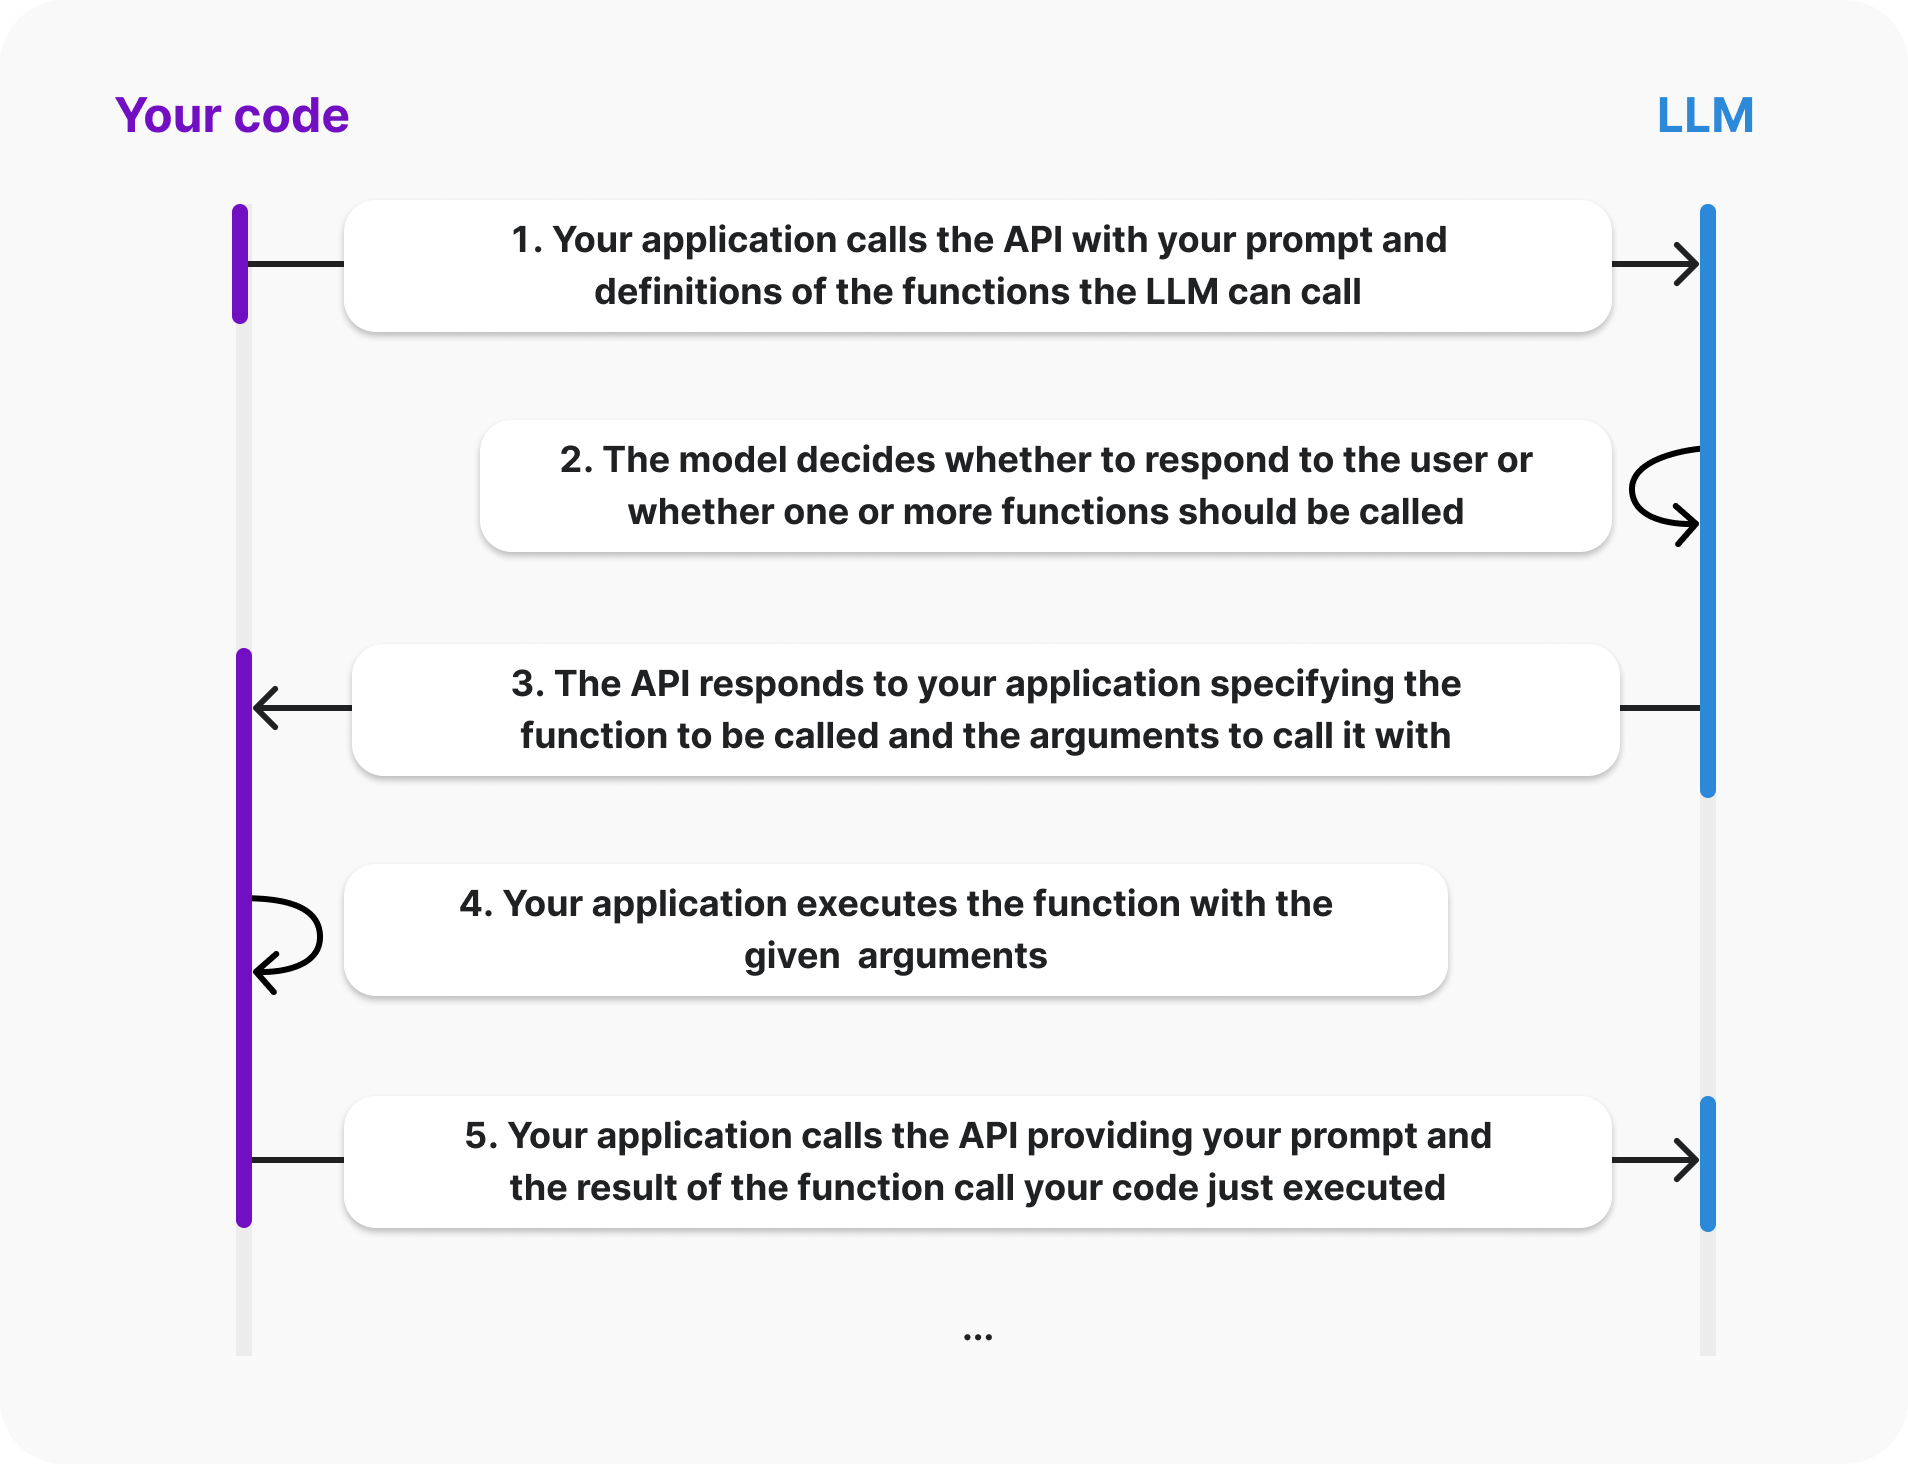

In [1]:
# load in the image
with open('demo.png', 'rb') as image:
    image_data = image.read()
# display the image
from IPython.display import Image
Image(image_data)


## An delivery system example
Let's say we would like to build a delivery system that can identify the address, order, date, and note of an order; and dump these information to a file.

In [2]:
def identify_order(
    to_address: str,
    order: str,
    date: str,
    notes: str,
) -> bool:
    with open('order.txt', 'w') as f:
        f.write(f"To: {to_address}\nOrder: {order}\nDate: {date}\nNote: {notes}")
    return True

def place_order(
    to_address: str,
    order: str,
    date: str,
    notes: str,
) -> bool:
    print(f'Take order for {to_address}, {order}, {date}, {notes}')
    return True

In [3]:
prompt = """
I would like to order two packs of cans, \
and have it delivered to 22 Fourth Avenue, Woodlands. \
I need this on the 11th of November. \
Just leave the order at the door, we live in a safe area.
"""

In [4]:
tools = [
    {
      "type": "function",
      "function": {
        "name": "identify_order",
        "description": "template to capture an order.",
        "parameters": {
          "type": "object",
          "properties": {
            "to_address": {
              "type": "string",
              "description": "To address for the delivery"
            },
            "order": {
              "type": "string",
              "description": "The detail of the order"
            },
            "date": {
              "type": "string",
              "description": "the date for delivery."
            },
            "notes": {
              "type": "string",
              "description": "Any delivery notes."
            }
          },
          "required": ["to_address", "order", "date", "notes"],
          "additionalProperties": False
        },
        "strict": True
      }
    },
    {
      "type": "function",
      "function": {
        "name": "place_order",
        "description": "place an order.",
        "parameters": {
          "type": "object",
          "properties": {
            "to_address": {
              "type": "string",
              "description": "To address for the delivery"
            },
          },
          "required": ["to_address"],
          "additionalProperties": False
        },
        "strict": True
      }
    }
]

In [5]:
from pathlib import Path
from dotenv import load_dotenv
import os
from openai import OpenAI
dotenv_path = Path('.env')
load_dotenv(dotenv_path=dotenv_path)

client = OpenAI(
    api_key=os.getenv('OPENAI_API_KEY'),
)

In [6]:
messages = [
    {"role": "user", "content": prompt}
]

response = client.beta.chat.completions.parse(
    model="gpt-4o-2024-08-06",
    messages=messages,
    tools=tools,
)

In [7]:
response.choices[0].message.tool_calls[0]

ParsedFunctionToolCall(id='call_0watW4hDjQw0Nhgj3SqjarqZ', function=ParsedFunction(arguments='{"to_address":"22 Fourth Avenue, Woodlands","order":"two packs of cans","date":"2024-07-27","notes":"Leave the order at the door, area is safe."}', name='identify_order', parsed_arguments={'to_address': '22 Fourth Avenue, Woodlands', 'order': 'two packs of cans', 'date': '2024-07-27', 'notes': 'Leave the order at the door, area is safe.'}), type='function')

In [8]:
print('**** Tool Call ****')
print(response.choices[0].message.tool_calls[0].function.name)
function_name = response.choices[0].message.tool_calls[0].function.name

print('**** Arguments ****')
print(response.choices[0].message.tool_calls[0].function.arguments)
arguments = eval(response.choices[0].message.tool_calls[0].function.arguments)

**** Tool Call ****
identify_order
**** Arguments ****
{"to_address":"22 Fourth Avenue, Woodlands","order":"two packs of cans","date":"2024-07-27","notes":"Leave the order at the door, area is safe."}


In [9]:
arguments

{'to_address': '22 Fourth Avenue, Woodlands',
 'order': 'two packs of cans',
 'date': '2024-07-27',
 'notes': 'Leave the order at the door, area is safe.'}

In [10]:
if function_name == 'identify_order':
    identify_order(**arguments)
elif function_name == 'place_order':
    place_order(**arguments)